In [0]:
#importing dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import gzip
import numpy as np
import random
import copy
try:
    import cPickle as pickle
except:
    import pickle

# Load Data

In [4]:
!git clone https://github.com/mnielsen/neural-networks-and-deep-learning.git

Cloning into 'neural-networks-and-deep-learning'...
remote: Enumerating objects: 1163, done.
remote: Total 1163 (delta 0), reused 0 (delta 0), pack-reused 1163
Receiving objects: 100% (1163/1163), 20.42 MiB | 36.95 MiB/s, done.
Resolving deltas: 100% (577/577), done.


In [5]:
%cd neural-networks-and-deep-learning/

/content/neural-networks-and-deep-learning


In [0]:
"""Class whose aim is to load data from the serialization file, and give it a
format to can be used in our code"""
class DataLoader(object):
  
  def load_data(self):
    with gzip.open('data/mnist.pkl.gz','rb') as ff :
        u = pickle._Unpickler( ff )
        u.encoding = 'latin1'
        training_data, validation_data, test_data= u.load()
    return (training_data, validation_data, test_data)
  
  def load_data_wrapper(self):
    tr_d, va_d, te_d = self.load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [ self.vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)
  
  def vectorized_result(self, j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [0]:
data_loader = DataLoader()
training_data, validation_data, test_data = data_loader.load_data_wrapper()
training_data, validation_data, test_data = list(training_data), \
list(validation_data), list(test_data)

(784, 1)


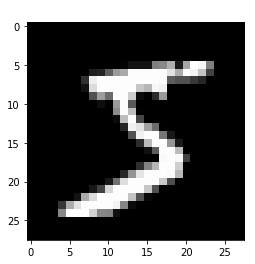

In [7]:
#inspecting the data
print(training_data[0][0].shape)
img = np.reshape(training_data[0][0], (28,28))
plt.imshow(img, cmap='gray')
title_obj = plt.title('Número: {}'.format(np.argmax(training_data[0][1])))
plt.setp(title_obj, color='w')  
plt.show()

#  Neural Network 

In [0]:
"""A class that implement a very basic SGD with sigmoid function, Gradients are 
calculated using backpropagation"""

class NeuralNetwork(object):
  
  @staticmethod
  def sigmoid(z): 
    return 1.0/(1.0+np.exp(-z))
  
  @staticmethod
  def sigmoid_prime(z):
    """"Derivative of the sigmoid function."""
    return NeuralNetwork.sigmoid(z) * (1 - NeuralNetwork.sigmoid(z))
  
  def __init__(self, sizes):
    self.num_layers = len(sizes)
    self.sizes = sizes 
    self.biases = [ np.random.rand(y,1) for y in sizes[1:]]
    self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
    
  def print_shapes(self):
    for weights, bias  in zip(self.weights, self.biases):
      print(weights.shape, bias.shape)
      
  def feedforward(self, a):
    for b, w in zip(self.biases, self.weights):
      a = NeuralNetwork.sigmoid(np.dot(w,a) + b)
    return a
  
  """Method that develops Stochastic Gradient Descent using mini batch"""
  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
    if test_data:
      n_test = len(test_data)
    n = len(training_data)
    for j in range(epochs):
      random.shuffle(training_data)
      mini_batches = [
                training_data[k:k+mini_batch_size]
           for k in range(0, n, mini_batch_size)]
      for mini_batch in mini_batches:
        self.update_mini_batch(mini_batch, eta)
      if test_data:
        print("Epoch {0}: {1} / {2}".format( j, 
                                            self.evaluate(test_data), n_test))
      else:
        print("Epoch {0} complete".format(j))
  
  def update_mini_batch(self, mini_batch, eta):
    """Update the network’s weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ‘‘mini_batch ‘‘ is a list of tuples ‘‘(x, y)‘‘, and ‘‘eta‘‘
    is the learning rate."""
    x, y = self.flat_batch(mini_batch)
    db, dw = self.backprop2(x,y)
    #bi = copy.deepcopy(self.biases)
    #wi = copy.deepcopy(self.weights)
    #wi = [w- (eta/len(mini_batch)) * nw for w, nw in zip(self.weights, dw)]
    #bi = [b- (eta/len(mini_batch)) * nb for b, nb in zip(self.biases, db)]
    self.weights = [w- (eta/len(mini_batch)) * nw 
                    for w, nw in zip(self.weights, dw)]
    self.biases = [b- (eta/len(mini_batch)) * nb 
                   for b, nb in zip(self.biases, db)]
    
    '''for w in wi:
      print(np.sum(w), w.shape)
    
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    for x, y in mini_batch:
      delta_nabla_b, delta_nabla_w = self.backprop(x, y)
      nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
      nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    self.weights = [w-(eta/len(mini_batch)) * nw
                        for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b-(eta/len(mini_batch)) * nb 
                   for b, nb in zip(self.biases, nabla_b)]
    for w in self.weights:
      print(np.sum(w), w.shape)
      '''
    
  def flat_batch(self, mini_batch):
    size = len(mini_batch)
    unziped = list(zip(*mini_batch)) 
    x = np.asarray(unziped[0])
    x = x.reshape(size, x.shape[1])
    y = np.asarray(unziped[1])
    y = y.reshape(size, y.shape[1])
    return x.T, y.T
      
  def backprop(self, x, y):
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(self.biases, self.weights):
      z = np.dot(w, activation) + b
      zs.append(z)
      #we are using sigmoid function for all layers
      activation = NeuralNetwork.sigmoid(z) 
      activations.append(activation)
    delta = self.cost_derivative(activations[-1], y) * \
    NeuralNetwork.sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].T)
    for l in range (2,self.num_layers):
      z = zs[-l]
      sp = NeuralNetwork.sigmoid_prime(z)
      delta = np.dot(self.weights[-l+1].T, delta) * sp
      nabla_b[-l] = delta
      nabla_w[-l] = np.dot(delta, activations[-l-1].T)
      return (nabla_b, nabla_w)
  
  
  def backprop2(self, x, y):
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(self.biases, self.weights):
      z = np.dot(w, activation) + b
      zs.append(z)
      #we are using sigmoid function for all layers
      activation = NeuralNetwork.sigmoid(z) 
      activations.append(activation)
    delta = self.cost_derivative(activations[-1], y) * \
    NeuralNetwork.sigmoid_prime(zs[-1])
    nabla_b[-1] = np.sum(delta, axis = 1).reshape(delta.shape[0],1)
    nabla_w[-1] = np.dot(delta, activations[-2].T) ## 10,100 100,15
    #nabla_w[-1] = np.dot(delt, act.T)
    
    for l in range (2,self.num_layers):
      z = zs[-l]
      sp = NeuralNetwork.sigmoid_prime(z)
      delta = np.dot(self.weights[-l+1].T, delta) * sp
      nabla_b[-l] = np.sum(delta, axis = 1).reshape(delta.shape[0],1)
      nabla_w[-l] = np.dot(delta, activations[-l-1].T)
      return (nabla_b, nabla_w)

  def evaluate(self, test_data):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    test_results = [(np.argmax(self.feedforward(x)), y)
                    for (x, y) in test_data]
    return sum(int(x == y) for (x, y) in test_results)
    
  def cost_derivative(self, output_activations, y):
    """The derivative of cuadratic error = a-y where a is the final output 
    activation and y is the ground truth label"""
    return (output_activations - y)

In [50]:
nn = NeuralNetwork([784,100,10])
nn.print_shapes()

(100, 784) (100, 1)
(10, 100) (10, 1)


In [51]:
nn.SGD(training_data,30,10,3, test_data= test_data)

Epoch 0: 7491 / 10000
Epoch 1: 7687 / 10000
Epoch 2: 8517 / 10000
Epoch 3: 9377 / 10000
Epoch 4: 9454 / 10000
Epoch 5: 9502 / 10000
Epoch 6: 9555 / 10000
Epoch 7: 9529 / 10000
Epoch 8: 9570 / 10000
Epoch 9: 9590 / 10000
Epoch 10: 9620 / 10000
Epoch 11: 9589 / 10000
Epoch 12: 9613 / 10000
Epoch 13: 9618 / 10000
Epoch 14: 9621 / 10000
Epoch 15: 9611 / 10000
Epoch 16: 9615 / 10000
Epoch 17: 9623 / 10000
Epoch 18: 9619 / 10000
Epoch 19: 9618 / 10000
Epoch 20: 9620 / 10000
Epoch 21: 9607 / 10000
Epoch 22: 9629 / 10000
Epoch 23: 9625 / 10000
Epoch 24: 9623 / 10000
Epoch 25: 9634 / 10000
Epoch 26: 9645 / 10000
Epoch 27: 9649 / 10000
Epoch 28: 9629 / 10000
Epoch 29: 9652 / 10000


# Testing Neural Network

In [0]:
predicted = nn.feedforward(training_data[111][0])
print(np.argmax(predicted))
img = np.reshape(training_data[111][0], (28, 28))
plt.imshow(img, cmap='gray')

In [0]:
!pip install albumentations
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

In [0]:
!git clone https://github.com/Rodrigo-Burciaga/DataSets-and-Utils-NNDL.git

In [0]:
img = cv2.imread('DataSets-and-Utils-NNDL/n_2.jpg', 0)
plt.imshow(img, cmap='gray')
plt.show()
img_rs = cv2.resize(img, (28,28))
ret, thresh = cv2.threshold(img_rs, 127, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh, cmap='gray')
plt.show()
print(thresh.shape)

In [0]:
img_to_predict = np.reshape(thresh, (784,1))
predicted = nn.feedforward(img_to_predict)
img = np.reshape(img_to_predict, (28, 28))
title_obj = plt.title('Número predecido: {}'.format(np.argmax(predicted)))
plt.setp(title_obj, color='w')  
plt.imshow(img, cmap='gray')
plt.show()